In [1]:
import numpy as np
import optimizer
import sinkhorn_ops
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy.optimize import linear_sum_assignment
%matplotlib inline
from time import time
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import numpy as np

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
data_train = input_data.read_data_sets('/tmp/', one_hot=True).train 
data_test = input_data.read_data_sets('/tmp/', one_hot=True).test 


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Extracting /tmp/train-images-idx3-ubyte.gz
Extracting /tmp/train-labels-idx1-ubyte.gz
Extracting /tmp/t10k-images-idx3-ubyte.gz
Extracting /tmp/t10k-labels-idx1-ubyte.gz


In [2]:
from scipy.special import logsumexp
def sinkhorn(log_alpha, n_iters=20):

    for n in range(n_iters):
        log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
        log_alpha -= logsumexp(log_alpha, axis=0, keepdims=True)
        if n%10000==1:
            print(n)
    log_alpha -= logsumexp(log_alpha, axis=1, keepdims=True)
    return np.exp(log_alpha)

def batch_split(batch, n_squares_side, n_channels=1):
    if(n_channels ==1):
        #side = int(np.sqrt(batch.shape[1]))
        side =batch.shape[1]
    else:
        side = batch.shape[1]
    batch_size = batch.shape[0]
    n_squares = n_squares_side ** 2
    
    batch = np.reshape(batch, [-1, side, side, n_channels])
    batch = np.reshape(batch, [batch_size, n_squares_side, side/n_squares_side, side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    batch = np.reshape(batch, [batch_size, side/n_squares_side, n_squares, side/n_squares_side, n_channels])
    batch = np.transpose(batch, [0, 2, 1, 3, 4])
    return batch

def stack_batch_split(batch):
    return np.reshape(batch, [batch.shape[0]*batch.shape[1], batch.shape[2], batch.shape[3], batch.shape[4]])


def unflatten_batch(batch, n_channels=1):
    side_square = int(np.sqrt(batch.shape[2]/n_channels))
    return np.reshape(batch, [batch.shape[0], batch.shape[1], side_square, side_square, n_channels])

def join_batch_split(batch):
    batch_size = batch.shape[0]
    n_squares = batch.shape[1]
    side_quare = batch.shape[2]
    n_channels = batch.shape[4]
    n_squares_side = int(np.sqrt(n_squares))
    batch = np.transpose(batch, [0, 1, 3, 2, 4])
    batch = np.reshape(batch, [batch_size, n_squares_side, side_square*n_squares_side, side_square, n_channels])
    batch = np.transpose(batch, [0,1, 3,2,4])
    batch = np.reshape(batch, [batch_size, 1, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    batch = np.reshape(batch, [batch_size, side_square*n_squares_side, side_square*n_squares_side, n_channels])
    return batch

def resized_dims(n_squares_side):
    if(n_squares_side==2):
        side = 28
        side_square = 14
    if(n_squares_side==3):
        side = 27
        side_square = 9
    if(n_squares_side==4):
        side = 28
        side_square = 7
    if(n_squares_side==5):
        side = 30
        side_square = 6
    if(n_squares_side==6):
        side = 30
        side_square = 5
    if(n_squares_side==7):
        side = 28
        side_square = 4
    if(n_squares_side==8):
        side = 32
        side_square = 4
    if(n_squares_side==9):
        side = 27
        side_square = 3
    if(n_squares_side==16):
        side = 80
        side_square = 5
    if(n_squares_side==14):
        side = 196
        side_square = 14
    if(n_squares_side==18):
        side = 8*18
        side_square = 8
    if(n_squares_side==20):
        side = 7*20
        side_square = 7
    if(n_squares_side==25):
        side = 25*6
        side_square = 6
    if(n_squares_side==30):
        side = 30*5
        side_square = 5
    if (n_squares_side == 37):
        side = 37 * 4
        side_square = 4
    if (n_squares_side == 45):
        side = 45 * 3
        side_square = 3
    return side, side_square

def resize_batch_color(batch, side_new, n_channels):
    batch_new = np.zeros((batch.shape[0], side_new, side_new, n_channels))
    side = int(np.sqrt(batch.shape[1]))
    for i in range(batch.shape[0]):
        for c in range(n_channels):
            a = imresize(batch[i,:,:,c], [side_new, side_new])
            
            a = a/255.0
            batch_new[i,:,:,c] =a
    return batch_new


def soft_to_hard(soft_perm):
    
    a,b = linear_sum_assignment(-soft_perm)
    ma = np.zeros((np.shape(soft_perm)))
    for i in range(soft_perm.shape[0]):
        ma[i, b[i]] = 1
    return ma


def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data


In [3]:
# Define model params
batch_size = 20
n_iter_sinkhorn2 = 10
n_iter_sinkhorn = 200

temp = 0.05
temp2 =0.001

#mnist data
n_squares_side = 16
lr = 0.0005
n_channels = 1
rfield_size = 3
stride = 3
n_units = 5
keep_prob = 1.0
side_real = 28
opt = 'adam'
samples_per_num = 1
n_squares = n_squares_side **2
side, side_square = resized_dims(n_squares_side)
n_dim = int(side_square*side_square*n_channels)
print(n_dim)
n_dim_z = 128
n_dim_z2 = 256
n_dim_zp = 256
noise_factor = 0
np.random.seed(2)



25


In [4]:
#Now we define the main TF variables


real_split = tf.placeholder(tf.float32,[None, n_squares, side_square, side_square, n_channels])
real_split_tiled = tf.tile(real_split, [samples_per_num, 1, 1, 1, 1])
real_split_tiled = tf.reshape(real_split_tiled, [-1, n_squares, side_square ** 2* n_channels])

real_entire = tf.placeholder(tf.float32,[None, side_real, side_real, n_channels])
real_entire_tiled = tf.tile(real_entire,[samples_per_num,1,1,1])

global_step = tf.Variable(0, trainable=False)
stack_im = tf.placeholder(tf.float32,[None, side_square, side_square, 1])



Instructions for updating:
Colocations handled automatically by placer.


In [5]:

def create_z():
    #create the matrix of log_alpha, that will later will converted into a soft permutation
    #this relies on some NN processing (convolutional), see below
    fc = tf.contrib.layers.fully_connected
    flatten = tf.contrib.layers.flatten
    dropout = tf.contrib.layers.dropout
    def conv(input_image, kernel_shape, bias_shape):
        weights = tf.get_variable("weights", kernel_shape,
                                 initializer = tf.random_normal_initializer())
        biases = tf.get_variable("biases", bias_shape, 
                                initializer=tf.constant_initializer(-1))
        convolutional = tf.nn.conv2d(input_image, weights, 
                                     strides = [1, 1, 1, 1],
                                     padding="SAME")
        out_relu = tf.nn.relu(convolutional + biases)
        out_maxpool = tf.nn.max_pool(out_relu, 
                                    ksize=[1, stride, stride, 1],
                                   strides=[1, stride, stride, 1],
                                   padding="SAME")
        return out_maxpool
    def conv_and_fc(input_image, scope, n_dim_z):
        with tf.variable_scope(scope):
            conv_output = conv(input_image, [rfield_size, rfield_size, n_channels, n_units], [n_units])
        fully_connected_output_mean = dropout(tf.cast(fc(flatten(conv_output), n_dim_z, activation_fn = None), tf.float32),
                                        keep_prob)
        fully_connected_output_log_var = dropout(tf.cast(fc(flatten(conv_output), n_dim_z, activation_fn = None), tf.float32),
                                        keep_prob)
      
        return fully_connected_output_mean, fully_connected_output_log_var
    
    #with tf.variable_scope("model_params"):
    z_mean, z_log_var = conv_and_fc(real_entire_tiled,'n1', n_dim_z)
    z_mean_pieces, z_log_var_pieces = conv_and_fc(real_entire_tiled,'n2',n_dim_zp)
    #z_mean_pieces, z_log_var_pieces = conv_and_fc(stack_im,'n2',n_dim_zp)
    z_mean_pieces = tf.reshape(tf.tile(z_mean_pieces, [1, n_squares]), [batch_size*n_squares,n_dim_zp])
    #z_mean_pieces = tf.reshape(z_mean_pieces, [1, n_squares]), [batch_size*n_squares,n_dim_zp])
    
    z_log_var_pieces = tf.reshape(tf.tile(z_log_var_pieces, [1, n_squares]), [batch_size*n_squares,n_dim_zp])
    z_pieces = z_mean_pieces + tf.random.normal([batch_size*n_squares, n_dim_zp]) *tf.exp(z_log_var_pieces/2)
    aa = fc(z_pieces,1, activation_fn = None)
    
    z_pieces_fc = tf.contrib.distributions.Bernoulli(logits=aa/temp).mean()
    scrambled_split_tiled = tf.tile(tf.reshape(z_pieces_fc, [batch_size, n_squares, 1]), [1,1, n_channels*side_square**2])
    
    z  = z_mean + tf.random.normal([batch_size, n_dim_z]) *tf.exp(z_log_var/2)
    z1 = tf.reshape(fc(z, n_squares*n_dim_z2, activation_fn = None), [-1, n_squares, n_dim_z2])
    z2 = tf.reshape(fc(flatten(z_pieces), n_dim_z2, activation_fn = None), [-1,  n_dim_z2,  n_squares])
    cost = tf.nn.sigmoid(tf.matmul(z1,z2))
   
    return z,z_pieces, z_mean, z_log_var, z_mean_pieces, z_log_var_pieces, cost, scrambled_split_tiled, aa,z_pieces_fc

In [6]:


#ordered_inf = tf.matmul(inv_soft_perms_flat, scrambled_split_tiled)

z,z_pieces, z_mean, z_log_var, z_mean_pieces, z_log_var_pieces, cost, scrambled_split_tiled,aa,z_pieces_fc = create_z()
(soft_perms_inf2, _) = sinkhorn_ops.gumbel_sinkhorn(-cost, temp2, samples_per_num, noise_factor, n_iter_sinkhorn2, squeeze=False)
inv_soft_perms2 = tf.transpose(soft_perms_inf2, [0, 1, 3, 2])
inv_soft_perms2_flat = tf.reshape(tf.transpose(inv_soft_perms2, [1, 0, 2, 3]), [-1, n_squares, n_squares])

ordered_inf2 = tf.matmul(inv_soft_perms2_flat, scrambled_split_tiled)
 
rec_loss1 =tf.reduce_mean(tf.square(ordered_inf2 - real_split_tiled))
rec_loss =-tf.reduce_mean(tf.reduce_mean(real_split_tiled*tf.log(1e-5+ordered_inf2) +(1-real_split_tiled)*tf.log(1e-5+1-ordered_inf2),axis=0))*side_real**2

KL1 = 0.5 *tf.reduce_mean(tf.reduce_sum(1+z_log_var -tf.square(z_mean) -tf.exp(z_log_var), axis=1))
KL2 = 0.5 *tf.reduce_mean(tf.reduce_sum(1+z_log_var_pieces -tf.square(z_mean_pieces) -tf.exp(z_log_var_pieces), axis=1))
KL = KL1+KL2*n_squares
l2s_diff = rec_loss - KL

#l2s_diff = tf.reduce_mean(tf.square(ordered_inf2 - real_split_tiled))

opt = optimizer.set_optimizer(opt, lr, opt_eps=1e-8)
train_op = tf.contrib.training.create_train_op(l2s_diff, opt, global_step=global_step)


Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use tf.cast instead.


In [7]:

init_op=tf.initialize_all_variables()
sess=tf.InteractiveSession()
sess.run(init_op)
new = tf.trainable_variables()
print(new)
n_iter = 30000
for i in range(n_iter):
    if i<n_iter-1:
        ims,_=data_train.next_batch(batch_size)
    else:
        print('hola')
        ims,_=data_test.next_batch(batch_size)        
    ims = np.expand_dims(np.reshape(ims, [-1, 28,28]),axis=3)
    ims[ims>0.5]=1
    ims[ims<0.5]=0
    np_x = resize_batch_color(ims, side, n_channels)

    real_images_split = batch_split(np_x, n_squares_side, n_channels)
    stack_real_images_split = stack_batch_split(real_images_split)
    [o2,loss, rec_loss_np,KL_np,rec_loss1_np,_, sp2,cos,z_mean_pieces_np, z_pieces_fc_np,z_log_var_pieces_np,aa_np] = sess.run([ordered_inf2, l2s_diff,rec_loss,KL,rec_loss1,train_op, soft_perms_inf2,cost,z_mean_pieces,z_pieces_fc,z_log_var_pieces,aa],{real_split:real_images_split,real_entire:ims, stack_im:stack_real_images_split})
    if(i%10==0):
        print([i, loss, rec_loss_np, KL_np, rec_loss1_np])
    if i==n_iter-1:
        ogen = []
        sgen =[]
        for k in range(5):
            [oo2,ssp2,scrambled_pieces_split_np] = sess.run([ordered_inf2,soft_perms_inf2, scrambled_split_tiled],{z:np.random.normal(0,1,(batch_size, n_dim_z)),
                                                                 z_pieces:np.random.normal(0,1,(n_squares*batch_size, n_dim_zp))})
            ogen.append(oo2)
            sgen.append(ssp2)

   


Instructions for updating:
Use `tf.global_variables_initializer` instead.
[<tf.Variable 'n1/weights:0' shape=(3, 3, 1, 5) dtype=float32_ref>, <tf.Variable 'n1/biases:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'fully_connected/weights:0' shape=(500, 128) dtype=float32_ref>, <tf.Variable 'fully_connected/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'fully_connected_1/weights:0' shape=(500, 128) dtype=float32_ref>, <tf.Variable 'fully_connected_1/biases:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'n2/weights:0' shape=(3, 3, 1, 5) dtype=float32_ref>, <tf.Variable 'n2/biases:0' shape=(5,) dtype=float32_ref>, <tf.Variable 'fully_connected_2/weights:0' shape=(500, 256) dtype=float32_ref>, <tf.Variable 'fully_connected_2/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'fully_connected_3/weights:0' shape=(500, 256) dtype=float32_ref>, <tf.Variable 'fully_connected_3/biases:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'fully_connected_4/weights:0' shape=(256, 1) d

/home/gomena/.local/lib/python2.7/site-packages/ipykernel_launcher.py:105: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


[0, 18084.86, 2143.9211, -15940.9375, 0.37022242]
[10, 10725.111, 1043.734, -9681.377, 0.1684844]
[20, 8339.783, 855.28723, -7484.496, 0.22554524]
[30, 6472.409, 583.6417, -5888.7676, 0.17521812]
[40, 4867.7046, 483.16315, -4384.5415, 0.15975839]
[50, 5311.7754, 444.1611, -4867.6143, 0.15052152]
[60, 4066.6802, 473.13495, -3593.5452, 0.15060478]
[70, 4117.6113, 397.93024, -3719.681, 0.1390101]
[80, 3636.8257, 370.01688, -3266.8088, 0.1209899]
[90, 3637.3215, 388.70584, -3248.6157, 0.13550596]
[100, 3079.4026, 369.5783, -2709.8242, 0.12363073]
[110, 3379.9824, 377.23895, -3002.7434, 0.12747806]
[120, 2828.9795, 403.56628, -2425.4133, 0.14423694]
[130, 2838.0278, 422.94855, -2415.0793, 0.14176671]
[140, 2486.472, 403.68573, -2082.7861, 0.13675663]
[150, 2622.2468, 386.3129, -2235.9338, 0.1345364]
[160, 2294.8281, 381.90427, -1912.924, 0.13354526]
[170, 2152.44, 383.65244, -1768.7876, 0.13224141]
[180, 2196.283, 388.02737, -1808.2555, 0.13685757]
[190, 2328.8237, 405.05777, -1923.7659, 0.

[1610, 355.5274, 297.7687, -57.758705, 0.09084508]
[1620, 353.71432, 294.39972, -59.314613, 0.08996792]
[1630, 384.26932, 333.09937, -51.169945, 0.10719441]
[1640, 396.01242, 323.5253, -72.487114, 0.10127122]
[1650, 353.03278, 296.02948, -57.003284, 0.08830829]
[1660, 356.8744, 300.8511, -56.023273, 0.0906433]
[1670, 342.2779, 294.4486, -47.829277, 0.08872629]
[1680, 382.39886, 327.98364, -54.41523, 0.10398529]
[1690, 354.08676, 297.68414, -56.40261, 0.08923723]
[1700, 365.3993, 316.8088, -48.590485, 0.0999854]
[1710, 400.40576, 351.25458, -49.1512, 0.11465785]
[1720, 366.141, 313.01865, -53.12236, 0.09779077]
[1730, 372.3126, 324.51584, -47.796745, 0.10243164]
[1740, 391.45416, 337.82184, -53.63233, 0.1090561]
[1750, 360.2112, 314.69492, -45.51629, 0.09820391]
[1760, 367.62744, 321.0768, -46.55063, 0.10209764]
[1770, 372.76184, 321.87692, -50.88491, 0.100497626]
[1780, 366.24338, 318.44446, -47.798912, 0.098905995]
[1790, 373.59335, 324.54105, -49.0523, 0.10121502]
[1800, 346.33093, 2

[3180, 303.30463, 288.73825, -14.566377, 0.08739355]
[3190, 284.2696, 270.0218, -14.247803, 0.07926184]
[3200, 314.88037, 300.63748, -14.242886, 0.09482518]
[3210, 312.9065, 298.80435, -14.102144, 0.09322319]
[3220, 329.85858, 314.4854, -15.373169, 0.099948555]
[3230, 343.912, 327.52963, -16.382355, 0.1060288]
[3240, 320.8069, 307.01273, -13.794166, 0.094470926]
[3250, 293.22852, 278.98285, -14.245667, 0.08416458]
[3260, 342.56064, 328.24292, -14.317717, 0.10618695]
[3270, 346.5093, 333.86252, -12.646778, 0.109111264]
[3280, 317.67627, 302.70218, -14.974094, 0.09759089]
[3290, 315.83746, 301.2354, -14.602066, 0.09200416]
[3300, 340.1578, 324.5924, -15.565391, 0.10544259]
[3310, 306.85474, 293.03485, -13.819898, 0.090483434]
[3320, 321.09616, 305.59558, -15.500584, 0.09665638]
[3330, 319.1758, 304.88956, -14.286241, 0.09881381]
[3340, 302.33167, 290.19913, -12.132528, 0.08808621]
[3350, 335.55005, 320.33954, -15.210514, 0.10337848]
[3360, 326.6196, 313.94467, -12.674937, 0.099241145]
[3

[4740, 216.7256, 206.09892, -10.626684, 0.0627303]
[4750, 244.64711, 232.03355, -12.613555, 0.07225537]
[4760, 251.9282, 240.04614, -11.882059, 0.07824928]
[4770, 228.79578, 217.12093, -11.674855, 0.06615349]
[4780, 227.60294, 216.54741, -11.055519, 0.06885103]
[4790, 242.0224, 230.2296, -11.792803, 0.07520788]
[4800, 238.34435, 227.66176, -10.682585, 0.07130881]
[4810, 230.50844, 219.88667, -10.621766, 0.07041744]
[4820, 237.54459, 226.19144, -11.353155, 0.070999116]
[4830, 220.16182, 209.35841, -10.803412, 0.064117976]
[4840, 238.85971, 229.17693, -9.682785, 0.07188675]
[4850, 241.48143, 230.10837, -11.373061, 0.073277526]
[4860, 235.83798, 225.3284, -10.509579, 0.07161979]
[4870, 247.05106, 236.05348, -10.997566, 0.07661745]
[4880, 241.60431, 229.66704, -11.937272, 0.07176943]
[4890, 226.93008, 215.89984, -11.030241, 0.06597244]
[4900, 217.54863, 206.85518, -10.693449, 0.064197935]
[4910, 243.81873, 232.48053, -11.338192, 0.07387905]
[4920, 236.14566, 225.07423, -11.071419, 0.070006

[6310, 211.23584, 201.72496, -9.510872, 0.063627966]
[6320, 225.14143, 215.31364, -9.827789, 0.06992703]
[6330, 225.17598, 216.43358, -8.742398, 0.06890035]
[6340, 217.56117, 208.31075, -9.250423, 0.06548991]
[6350, 236.10983, 224.2713, -11.838535, 0.07341292]
[6360, 218.3894, 208.25278, -10.1366205, 0.06576216]
[6370, 231.68942, 221.19307, -10.49635, 0.07071249]
[6380, 210.46957, 200.77754, -9.692029, 0.06503232]
[6390, 212.45511, 203.31802, -9.137092, 0.06490492]
[6400, 220.8001, 211.7816, -9.01849, 0.06822852]
[6410, 229.14494, 219.4372, -9.707742, 0.06921234]
[6420, 219.60849, 211.56468, -8.043801, 0.06726607]
[6430, 231.03542, 221.93947, -9.095954, 0.071838416]
[6440, 218.80675, 209.96301, -8.843735, 0.065893665]
[6450, 203.81277, 193.50108, -10.311691, 0.06007877]
[6460, 209.09073, 200.45296, -8.637775, 0.06343397]
[6470, 217.53511, 209.11832, -8.416789, 0.066616446]
[6480, 225.83218, 218.03674, -7.7954445, 0.07073765]
[6490, 215.21971, 206.1107, -9.1090145, 0.0650486]
[6500, 233

[7890, 227.00839, 217.69502, -9.31337, 0.0706798]
[7900, 219.0113, 209.07431, -9.936992, 0.066522464]
[7910, 224.29112, 214.1584, -10.132727, 0.06835021]
[7920, 223.5415, 214.38205, -9.159456, 0.067899995]
[7930, 197.3103, 189.00801, -8.302288, 0.057442147]
[7940, 222.48315, 211.7458, -10.737358, 0.06808429]
[7950, 207.37053, 197.04591, -10.324611, 0.06198498]
[7960, 220.02374, 210.43472, -9.58902, 0.06841631]
[7970, 213.77542, 205.74673, -8.028694, 0.06497511]
[7980, 210.0592, 201.53316, -8.526048, 0.061533473]
[7990, 223.24963, 214.52974, -8.719897, 0.06854852]
[8000, 217.12956, 208.23311, -8.896452, 0.06706666]
[8010, 212.7862, 204.3032, -8.48299, 0.0629677]
[8020, 215.78786, 207.30127, -8.486587, 0.06623668]
[8030, 222.97896, 213.9542, -9.024769, 0.06817218]
[8040, 214.92186, 204.69165, -10.230204, 0.065067746]
[8050, 219.59506, 208.6281, -10.966957, 0.06704608]
[8060, 223.37378, 212.65877, -10.715006, 0.068286315]
[8070, 211.94955, 202.73392, -9.21563, 0.06454972]
[8080, 215.7857,

[9470, 197.78589, 189.14624, -8.639654, 0.058269154]
[9480, 196.12537, 187.74509, -8.3802805, 0.058280434]
[9490, 212.23848, 201.88864, -10.349844, 0.06498639]
[9500, 239.24379, 229.28308, -9.960709, 0.07377116]
[9510, 221.66357, 212.91615, -8.747421, 0.06858081]
[9520, 218.62659, 209.2696, -9.356983, 0.0666143]
[9530, 209.55746, 200.6634, -8.894061, 0.062902115]
[9540, 206.34842, 198.00954, -8.338882, 0.06042279]
[9550, 224.24393, 214.81943, -9.424503, 0.068846725]
[9560, 202.26622, 193.42258, -8.843641, 0.06095258]
[9570, 207.60722, 198.1179, -9.489318, 0.062860206]
[9580, 232.75572, 222.43147, -10.324255, 0.071656324]
[9590, 212.50307, 203.17122, -9.331855, 0.06535012]
[9600, 218.70673, 210.89612, -7.810609, 0.06747548]
[9610, 211.80504, 203.36044, -8.444601, 0.065048985]
[9620, 202.0527, 192.63454, -9.418164, 0.0600654]
[9630, 211.91412, 203.04347, -8.8706455, 0.06390353]
[9640, 202.35239, 194.41037, -7.9420166, 0.05873866]
[9650, 235.27887, 224.60185, -10.677022, 0.07255674]
[9660

[11030, 202.71805, 194.10681, -8.6112385, 0.061289623]
[11040, 194.1984, 185.75555, -8.442835, 0.05568109]
[11050, 207.78394, 197.63046, -10.153475, 0.062298484]
[11060, 205.40747, 196.20245, -9.205013, 0.061888587]
[11070, 206.13754, 197.13521, -9.002327, 0.059795294]
[11080, 209.86499, 202.01736, -7.8476267, 0.061824545]
[11090, 197.14824, 187.73819, -9.410048, 0.057908975]
[11100, 215.98283, 207.15088, -8.831959, 0.06302978]
[11110, 235.20856, 226.90599, -8.302564, 0.07347343]
[11120, 202.28006, 193.70709, -8.572971, 0.062309273]
[11130, 205.61304, 197.21645, -8.3965845, 0.061555002]
[11140, 207.91736, 199.6949, -8.22246, 0.06364137]
[11150, 208.36868, 199.69112, -8.67756, 0.063147925]
[11160, 215.54604, 206.63821, -8.907816, 0.06657404]
[11170, 212.8626, 204.24486, -8.61774, 0.06469367]
[11180, 238.56595, 230.0609, -8.505049, 0.07574468]
[11190, 215.00749, 206.41757, -8.589913, 0.06582205]
[11200, 223.14386, 214.58757, -8.556284, 0.06954442]
[11210, 210.59294, 202.61969, -7.973254,

[12580, 222.22789, 212.81651, -9.411375, 0.066830456]
[12590, 199.35164, 190.16286, -9.1887865, 0.060100507]
[12600, 214.19803, 204.94801, -9.250008, 0.06542247]
[12610, 210.95583, 201.07469, -9.881139, 0.061503004]
[12620, 214.61441, 205.5014, -9.113002, 0.064230025]
[12630, 205.62947, 196.40393, -9.225536, 0.06174664]
[12640, 217.13838, 209.13947, -7.9989233, 0.066167]
[12650, 218.51036, 208.40169, -10.108677, 0.06666591]
[12660, 213.21826, 202.58034, -10.637924, 0.06402092]
[12670, 232.02997, 224.17471, -7.8552523, 0.07274722]
[12680, 223.24799, 214.96454, -8.283452, 0.0681596]
[12690, 219.97446, 210.58354, -9.390923, 0.066485256]
[12700, 208.99948, 200.71945, -8.280023, 0.062010758]
[12710, 230.16406, 221.98088, -8.183189, 0.070867516]
[12720, 202.14868, 194.0353, -8.113382, 0.059662048]
[12730, 197.55403, 189.2843, -8.26973, 0.057437707]
[12740, 219.89264, 210.74673, -9.14591, 0.06669365]
[12750, 248.40619, 240.01225, -8.3939295, 0.07952435]
[12760, 191.7455, 183.15955, -8.585947,

[14130, 210.63817, 201.76167, -8.876491, 0.06257843]
[14140, 206.58551, 197.79205, -8.793455, 0.061708692]
[14150, 222.97353, 212.95917, -10.0143585, 0.06756282]
[14160, 216.25246, 207.09074, -9.161713, 0.0651901]
[14170, 206.84592, 198.84373, -8.002174, 0.06006887]
[14180, 213.3346, 204.86908, -8.465517, 0.06372817]
[14190, 215.31598, 206.44075, -8.875233, 0.06407449]
[14200, 198.10455, 189.41586, -8.688683, 0.058550566]
[14210, 223.94707, 215.00821, -8.938852, 0.06983167]
[14220, 232.48033, 222.50168, -9.978659, 0.07264954]
[14230, 212.196, 204.1575, -8.038501, 0.06477194]
[14240, 218.6531, 210.9753, -7.6778116, 0.06768875]
[14250, 213.36992, 205.22346, -8.146453, 0.065406404]
[14260, 216.86743, 208.29535, -8.572085, 0.065268844]
[14270, 215.4642, 206.9691, -8.495108, 0.06583624]
[14280, 210.47, 201.7963, -8.673709, 0.06323827]
[14290, 218.42433, 210.44804, -7.9762883, 0.06727307]
[14300, 221.86855, 213.37248, -8.496059, 0.06793402]
[14310, 211.21912, 200.5101, -10.709014, 0.06471579

[15680, 223.38727, 213.47159, -9.91568, 0.068252444]
[15690, 226.31558, 216.44725, -9.868339, 0.07009741]
[15700, 213.22612, 204.35063, -8.875494, 0.06344645]
[15710, 224.27472, 214.11494, -10.1597805, 0.06994048]
[15720, 219.82259, 209.46605, -10.356541, 0.067473724]
[15730, 231.30853, 222.1497, -9.1588335, 0.07136623]
[15740, 209.15024, 198.54439, -10.605851, 0.06322153]
[15750, 234.41675, 224.51904, -9.897711, 0.072655335]
[15760, 211.516, 202.53824, -8.977762, 0.063376755]
[15770, 213.28635, 204.02997, -9.256382, 0.06504367]
[15780, 196.70439, 187.77812, -8.926263, 0.056547724]
[15790, 222.84506, 214.21951, -8.625542, 0.06857639]
[15800, 206.87788, 197.90501, -8.972874, 0.060878836]
[15810, 198.24756, 188.80739, -9.440175, 0.058590725]
[15820, 208.16144, 198.32697, -9.834466, 0.06269307]
[15830, 210.41367, 201.55215, -8.861505, 0.06374869]
[15840, 204.84435, 196.172, -8.672343, 0.06224074]
[15850, 209.7669, 200.2329, -9.534019, 0.06264692]
[15860, 233.99124, 224.64845, -9.342789, 0

[17230, 202.11908, 192.7823, -9.336779, 0.059641898]
[17240, 214.81888, 204.6091, -10.209776, 0.06463008]
[17250, 188.32684, 178.72664, -9.600197, 0.05421211]
[17260, 200.57329, 190.89525, -9.678034, 0.05889091]
[17270, 210.11613, 200.023, -10.093143, 0.06283394]
[17280, 200.76389, 191.8652, -8.898681, 0.058105122]
[17290, 215.43796, 205.2577, -10.180256, 0.06355704]
[17300, 219.41557, 209.1287, -10.286881, 0.06736183]
[17310, 204.68994, 195.09845, -9.591498, 0.060962077]
[17320, 213.22041, 203.0121, -10.208313, 0.06479222]
[17330, 202.88246, 193.21587, -9.666595, 0.059567254]
[17340, 200.60918, 191.56941, -9.0397625, 0.058469925]
[17350, 212.14328, 200.7798, -11.3634815, 0.062273413]
[17360, 196.94823, 186.26189, -10.686346, 0.056608733]
[17370, 214.3278, 204.77226, -9.555545, 0.064202085]
[17380, 226.8237, 217.31929, -9.504403, 0.06928868]
[17390, 200.96425, 191.43524, -9.529014, 0.05857512]
[17400, 201.1614, 191.20155, -9.959856, 0.059826057]
[17410, 222.1029, 212.6794, -9.423502, 0

[18760, 220.49332, 209.23233, -11.260986, 0.06597484]
[18770, 207.67406, 197.80562, -9.868434, 0.061000943]
[18780, 218.01102, 207.37192, -10.639098, 0.06646562]
[18790, 207.35034, 197.38985, -9.960487, 0.06235472]
[18800, 206.68735, 197.1619, -9.525456, 0.060442504]
[18810, 218.85962, 209.40253, -9.457091, 0.065519445]
[18820, 214.35254, 204.62767, -9.7248745, 0.063714854]
[18830, 213.52827, 203.34605, -10.182215, 0.065295026]
[18840, 222.68521, 211.57304, -11.112171, 0.06711459]
[18850, 203.25125, 192.18748, -11.063772, 0.06109936]
[18860, 231.9634, 220.10445, -11.858942, 0.07395058]
[18870, 219.29187, 207.35542, -11.936443, 0.06470871]
[18880, 216.75458, 206.48608, -10.268497, 0.064846694]
[18890, 230.63277, 219.56673, -11.066034, 0.070393994]
[18900, 225.57674, 215.19792, -10.37881, 0.06869795]
[18910, 222.36841, 211.91922, -10.44919, 0.06723943]
[18920, 193.0657, 183.48074, -9.584964, 0.055887483]
[18930, 201.8487, 191.85095, -9.997742, 0.060563512]
[18940, 213.07068, 202.55927, -

[20290, 214.02274, 203.13028, -10.89245, 0.063682]
[20300, 207.1936, 196.07495, -11.118654, 0.061654367]
[20310, 223.11707, 212.78363, -10.33343, 0.06735402]
[20320, 227.88298, 217.55457, -10.328412, 0.068619296]
[20330, 212.52013, 202.50356, -10.016568, 0.06390572]
[20340, 194.93524, 183.35379, -11.58145, 0.056693796]
[20350, 185.0877, 174.62094, -10.466769, 0.051729407]
[20360, 232.08319, 221.5375, -10.545685, 0.07103573]
[20370, 212.54893, 202.4502, -10.098736, 0.06392869]
[20380, 209.80772, 199.01306, -10.794668, 0.061940588]
[20390, 218.21584, 208.80186, -9.413965, 0.06546135]
[20400, 209.3027, 199.0191, -10.283596, 0.06296668]
[20410, 207.59552, 197.36449, -10.231031, 0.06167804]
[20420, 196.87144, 185.909, -10.962454, 0.05620467]
[20430, 209.99548, 200.18439, -9.811096, 0.062732555]
[20440, 223.78276, 212.37025, -11.412504, 0.066399366]
[20450, 213.15451, 202.94383, -10.210672, 0.064957626]
[20460, 214.69551, 203.51762, -11.177885, 0.062434733]
[20470, 208.00114, 197.45464, -10.

[21820, 218.76512, 208.3812, -10.383928, 0.067154065]
[21830, 205.29294, 194.91518, -10.377754, 0.061314616]
[21840, 191.26979, 181.28885, -9.980945, 0.054777898]
[21850, 219.37529, 208.47935, -10.895937, 0.06696077]
[21860, 209.25156, 198.57304, -10.678518, 0.06130934]
[21870, 211.4916, 200.89796, -10.593622, 0.06350206]
[21880, 204.0316, 193.54092, -10.490671, 0.058058236]
[21890, 236.91875, 226.44658, -10.472169, 0.07362269]
[21900, 210.43857, 200.167, -10.271557, 0.062133394]
[21910, 213.03288, 201.78195, -11.250937, 0.06317469]
[21920, 214.04018, 203.74927, -10.290907, 0.06556434]
[21930, 200.44551, 189.70421, -10.741297, 0.058953512]
[21940, 228.807, 217.2513, -11.555704, 0.068329856]
[21950, 226.0711, 215.12097, -10.950142, 0.06974187]
[21960, 205.1763, 192.90756, -12.268742, 0.0605006]
[21970, 216.36838, 205.38287, -10.9855, 0.065670796]
[21980, 191.6439, 180.65279, -10.991125, 0.05487789]
[21990, 210.3342, 199.86511, -10.469084, 0.062065076]
[22000, 221.02486, 209.88553, -11.1

[23340, 215.80945, 205.00626, -10.803196, 0.06360815]
[23350, 211.74818, 200.66495, -11.083237, 0.062889695]
[23360, 211.3874, 200.11147, -11.275938, 0.063038096]
[23370, 227.09561, 215.93413, -11.16148, 0.069285594]
[23380, 208.26485, 197.45389, -10.810953, 0.06131613]
[23390, 215.85905, 204.67073, -11.188322, 0.06379024]
[23400, 200.96342, 191.47894, -9.484478, 0.057265945]
[23410, 209.91846, 198.10669, -11.811773, 0.063426726]
[23420, 212.17699, 200.85126, -11.325723, 0.063542776]
[23430, 213.09233, 202.48381, -10.6085205, 0.063008495]
[23440, 213.62025, 202.18309, -11.437161, 0.063496485]
[23450, 212.85117, 201.67352, -11.177638, 0.063440196]
[23460, 216.04526, 205.65701, -10.388245, 0.063665226]
[23470, 226.1564, 213.81042, -12.345985, 0.06729302]
[23480, 215.08278, 204.55971, -10.523073, 0.0650658]
[23490, 219.30487, 208.24763, -11.057243, 0.06756123]
[23500, 193.60884, 183.9802, -9.628654, 0.05630221]
[23510, 211.38422, 200.58609, -10.798124, 0.06258686]
[23520, 196.24512, 185.1

[24860, 191.81526, 181.86703, -9.948231, 0.054402575]
[24870, 220.10002, 208.59445, -11.505565, 0.06695472]
[24880, 215.57738, 204.38062, -11.196756, 0.061851587]
[24890, 222.22945, 210.32828, -11.90117, 0.06709359]
[24900, 213.46394, 201.90953, -11.554409, 0.06458476]
[24910, 215.11252, 203.1007, -12.011833, 0.064825624]
[24920, 213.61188, 202.03346, -11.578417, 0.06227941]
[24930, 212.42395, 200.09021, -12.3337345, 0.062683985]
[24940, 222.94484, 209.8431, -13.101749, 0.068558365]
[24950, 230.92133, 218.30394, -12.617388, 0.06967737]
[24960, 206.48555, 194.83699, -11.648558, 0.060000047]
[24970, 201.87506, 191.45987, -10.415199, 0.058344293]
[24980, 210.52225, 199.14018, -11.38206, 0.06279212]
[24990, 207.6979, 196.80205, -10.895861, 0.061423786]
[25000, 223.66753, 213.0564, -10.611135, 0.0685108]
[25010, 218.68613, 207.24385, -11.44228, 0.06500494]
[25020, 199.10072, 188.76, -10.340727, 0.056975618]
[25030, 199.42424, 189.43523, -9.989016, 0.05902049]
[25040, 209.36923, 198.83731, -

[26390, 217.64876, 202.578, -15.070759, 0.06386505]
[26400, 216.25986, 205.15631, -11.103551, 0.065565534]
[26410, 208.80461, 198.17871, -10.625903, 0.060578723]
[26420, 213.0004, 201.05946, -11.940939, 0.062900946]
[26430, 204.53287, 192.3591, -12.173759, 0.058760524]
[26440, 200.42107, 186.92705, -13.494012, 0.05769654]
[26450, 218.9356, 207.62473, -11.310863, 0.06508323]
[26460, 200.47438, 188.80551, -11.668865, 0.058120824]
[26470, 199.33325, 187.64912, -11.684135, 0.056707893]
[26480, 213.44508, 201.83177, -11.613309, 0.061190087]
[26490, 224.02885, 212.83286, -11.195992, 0.06890527]
[26500, 224.48221, 211.42825, -13.053961, 0.06767975]
[26510, 208.43916, 196.24686, -12.192306, 0.061076716]
[26520, 212.30309, 200.28548, -12.017602, 0.06372338]
[26530, 214.68686, 203.01372, -11.673141, 0.0630838]
[26540, 223.353, 210.85703, -12.4959755, 0.06728318]
[26550, 208.39265, 196.81062, -11.58203, 0.059970092]
[26560, 212.37057, 201.09737, -11.273207, 0.06348253]
[26570, 218.48997, 206.6904

[27910, 219.23225, 208.35724, -10.875009, 0.06504471]
[27920, 208.19437, 197.85188, -10.342476, 0.06266533]
[27930, 205.7504, 194.17567, -11.574715, 0.05961571]
[27940, 218.51959, 206.7655, -11.754082, 0.06589554]
[27950, 221.45201, 209.56648, -11.885525, 0.06548392]
[27960, 216.17624, 203.8689, -12.307349, 0.063998416]
[27970, 207.02806, 196.8285, -10.19956, 0.061557148]
[27980, 211.3113, 200.41852, -10.892771, 0.062059496]
[27990, 201.74503, 190.361, -11.384026, 0.059262224]
[28000, 206.38196, 194.34412, -12.037834, 0.060904335]
[28010, 218.1181, 207.37663, -10.741478, 0.06519093]
[28020, 216.42406, 204.08339, -12.34067, 0.06374681]
[28030, 213.68547, 201.12526, -12.560211, 0.06338062]
[28040, 220.7966, 209.5932, -11.203407, 0.06659153]
[28050, 215.1589, 202.20946, -12.949453, 0.06276086]
[28060, 207.03668, 195.42877, -11.607904, 0.0607041]
[28070, 209.71597, 197.04134, -12.674635, 0.061908517]
[28080, 218.06796, 205.20923, -12.858728, 0.06355763]
[28090, 200.97531, 187.68803, -13.28

[29430, 210.054, 198.6942, -11.359808, 0.062464852]
[29440, 202.05528, 188.9648, -13.090479, 0.05772782]
[29450, 237.31842, 227.03496, -10.283457, 0.07161981]
[29460, 210.53192, 200.7763, -9.755614, 0.06235904]
[29470, 211.65782, 199.38774, -12.270084, 0.06270658]
[29480, 220.5282, 207.81102, -12.717171, 0.06451123]
[29490, 206.12105, 195.09561, -11.025442, 0.05953698]
[29500, 216.54784, 203.38278, -13.165055, 0.063588716]
[29510, 212.22046, 201.10652, -11.113942, 0.06282075]
[29520, 217.35803, 205.99948, -11.358547, 0.065478444]
[29530, 230.28989, 217.5249, -12.764984, 0.06829763]
[29540, 227.47511, 216.27925, -11.195861, 0.07122317]
[29550, 199.57541, 188.57634, -10.999074, 0.057637412]
[29560, 208.68814, 196.32187, -12.366272, 0.061741505]
[29570, 204.45134, 191.21732, -13.234018, 0.059780195]
[29580, 212.5193, 201.34834, -11.170958, 0.06238318]
[29590, 200.3551, 190.56499, -9.790109, 0.058027886]
[29600, 212.408, 201.32709, -11.080922, 0.062276665]
[29610, 224.0549, 211.23247, -12.

In [8]:
real_images_split = batch_split(np_x, n_squares_side, n_channels)
stack_real_images_split = stack_batch_split(real_images_split)
print(stack_real_images_split.shape)

(5120, 5, 5, 1)


In [20]:
batch_size_display = 10
hard = np.zeros(sp2.shape)
ind=3
scrambled_pieces = unflatten_batch(scrambled_pieces_split_np, n_channels)
joined_scrambled = join_batch_split(scrambled_pieces)
for i in range(batch_size_display):
    hard[i,0,:,:] =soft_to_hard(np.transpose(sgen[ind][i,0,:,:]))
    
unscrambled_images_hard =  np.matmul(hard[:batch_size_display,0,:,:], np.reshape(scrambled_pieces[:batch_size_display,:,:,:], [batch_size_display,n_squares_side **2 ,-1]))
unscrambled_images_soft =  ogen[ind]
unflatten_inf_hard = unflatten_batch(unscrambled_images_hard, n_channels)
joined_inf_hard = join_batch_split(unflatten_inf_hard)
unflatten_inf_soft = unflatten_batch(unscrambled_images_soft, n_channels)
joined_inf_soft = join_batch_split(unflatten_inf_soft)


In [21]:
unscrambled_images_hard =  o2
unflatten_inf_hard = unflatten_batch(unscrambled_images_hard, n_channels)
joined_inf_hard = join_batch_split(unflatten_inf_hard)


(20, 80, 80, 1)


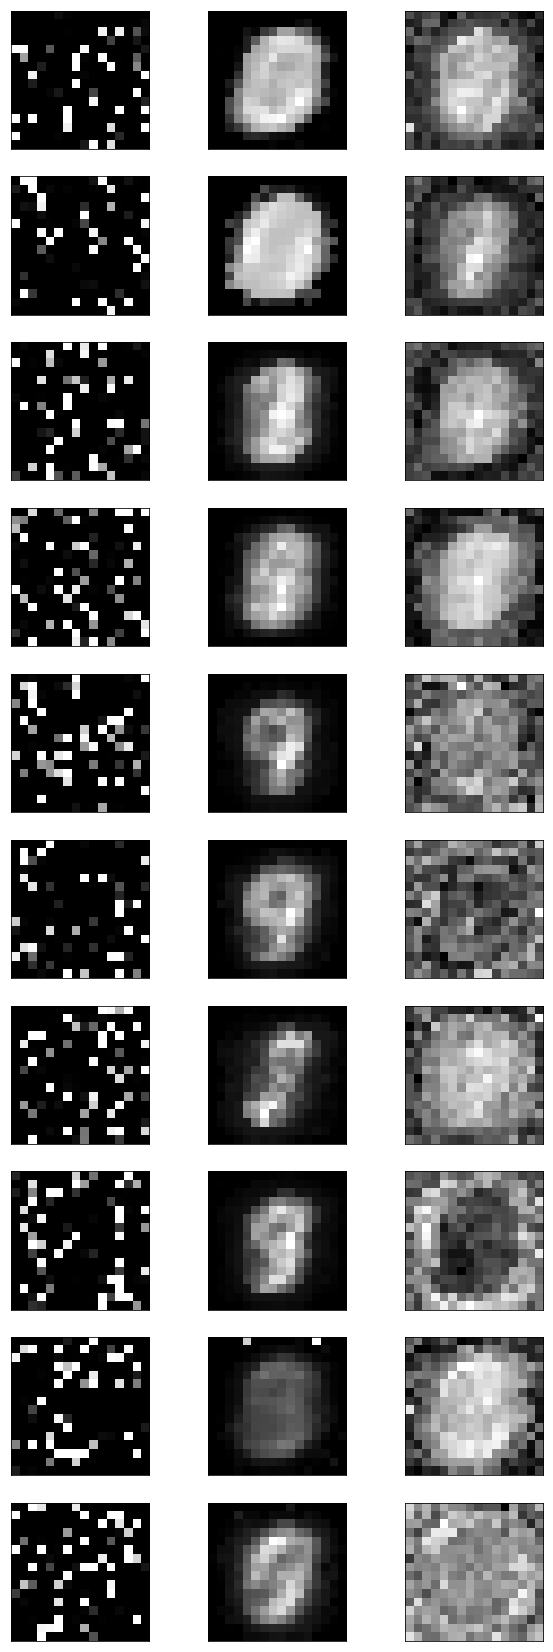

In [19]:
fig,ax=plt.subplots(10,3,figsize=(10,30))
#plt.imshow(joined_inf[0,:,:,0])
print(np_x.shape)
for i in range(10):
    
    
    ax[i,1].imshow(joined_inf_hard[i,:,:,0],'gray')
    ax[i,2].imshow(joined_inf_soft[i,:,:,0],'gray')
    ax[i,0].imshow(joined_scrambled[i,:,:,0],'gray')
    for k in range(3):
        ax[i,k].get_xaxis().set_visible(False)
        ax[i,k].get_yaxis().set_visible(False)

[0.99921334 0.9980155  0.99917245 0.99774873 1.0015651  1.0015223
 0.9985361  0.9988259  0.9985856  1.0001013  0.9978211  1.0009725
 1.0007739  1.0008395  0.99896467 0.9979242  1.0012058  1.0009766
 0.99906754 1.0008426  0.9999008  0.99912417 1.0017183  0.9982082
 0.9978326  1.0015237  1.0012887  1.0000681  1.001688   1.0001459
 0.99818444 0.9992247  1.0013493  1.0008035  0.9979409  1.0004674
 1.0013511  1.0004288  1.0008175  0.9988837  1.0011756  0.9986218
 1.0015255  1.0010061  1.0015008  0.9979113  1.0015118  0.99848014
 1.000657   0.9990794  1.0014963  0.99987495 1.0000954  1.0008671
 1.0001348  0.99845386 1.0002797  0.9997923  0.9996867  1.0010886
 0.9984001  1.0005425  1.0016769  0.99866164 1.0014073  1.0015807
 0.99998933 1.0010986  0.9999579  1.0007092  0.99874175 0.99773866
 1.001538   1.0000064  0.9979506  1.0011711  0.9977754  0.9984559
 0.9988593  1.0010747  0.99909776 1.0016133  0.998717   1.0013621
 1.0011278  1.0014746  1.0009749  1.0005983  1.0014398  0.9981612
 1.00146

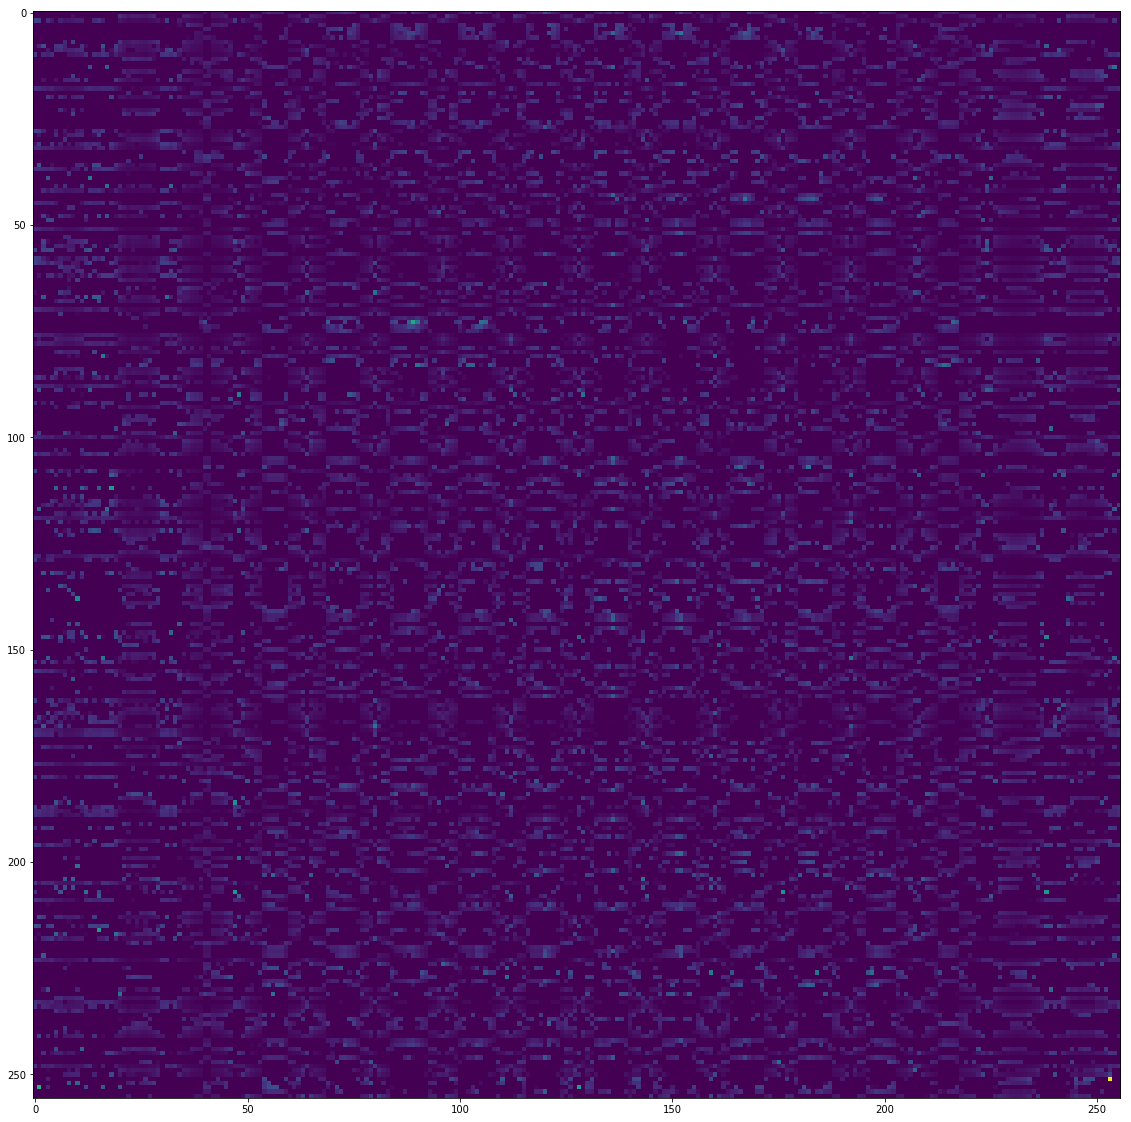

In [13]:
print(np.sum(ssp2[0,0,:,:], axis=1))
plt.figure(figsize=(20,20))
plt.imshow(ssp2[5,0,:,:])
print(ssp2[0,0,0,:])

In [14]:
print(np_x)

[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.

In [15]:

joined_inf_hard = join_batch_split(unflatten_batch(o2, n_channels))